The sGA best solution is: (0, [2.1425363466494343e-06, -1.1294865482890587e-05, 1.8933524600477164e-06, -2.240406121740247e-06, 4.1966261074938995e-06])
The cGA best solution is: (0, array([ 3.82451169e-06, -2.73728394e-06, -1.58617882e-06, -1.44489082e-06,
        7.99844600e-07]))


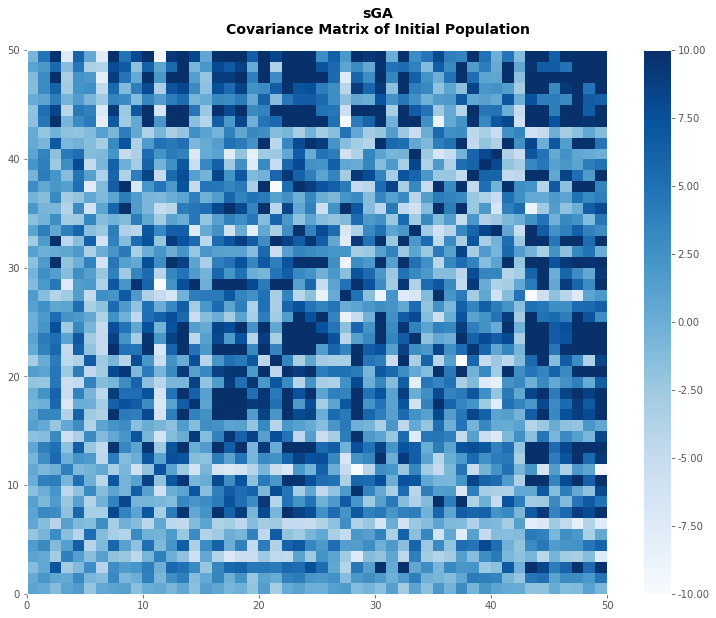

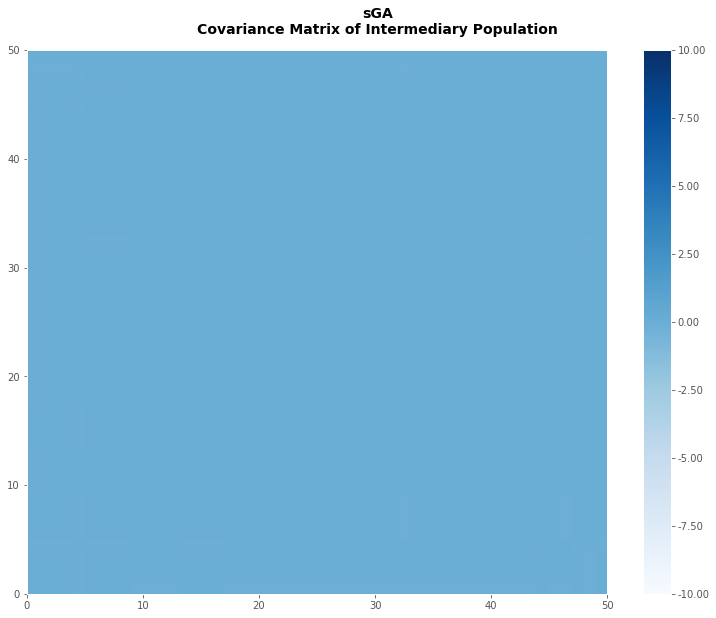

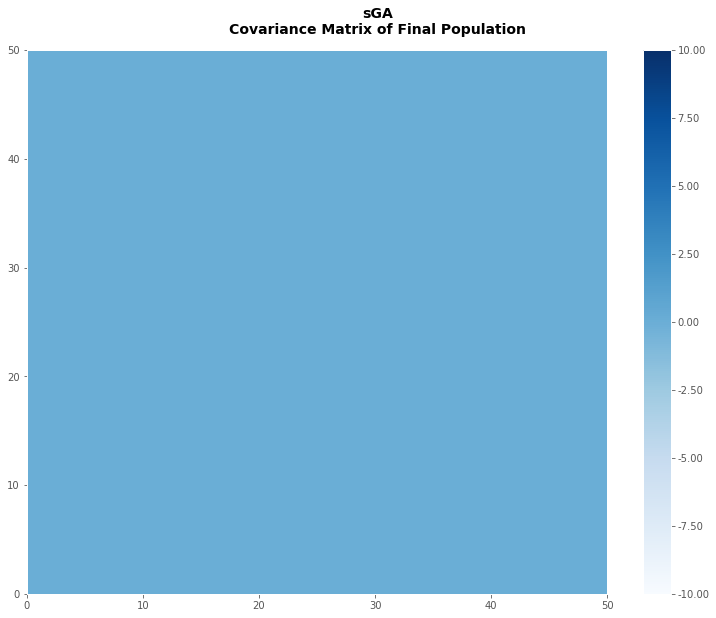

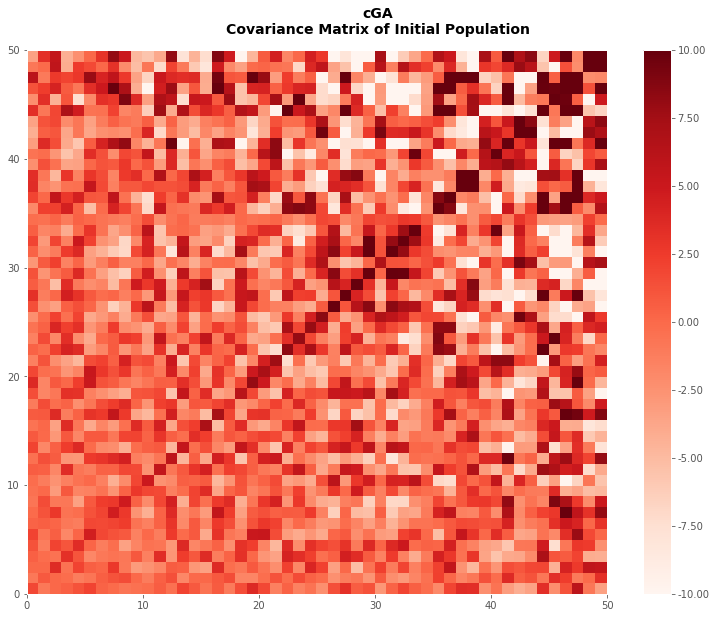

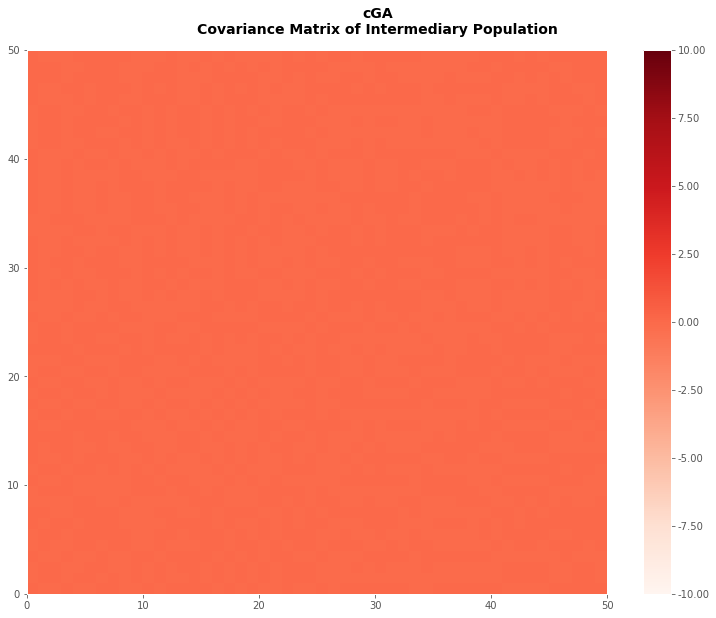

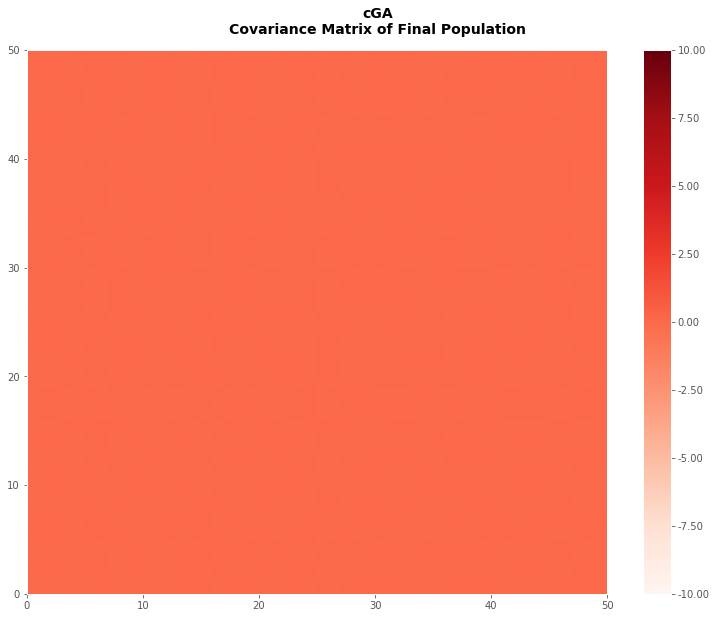

In [84]:
################################################################################
## Imports

import sys
import math
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import random
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Error
ERR = 1e-10

# Data
data = [0] * 5

# Define fitness function
def fitness_function(individual, data=None):
  sum = 0
  for u in individual:
    sum += (u ** 2)
  return sum

# Define the key field for sorting
def get_key(obj):
  return obj.fitness

def round_up(n, decimals=10):
  multiplier = 10 ** decimals
  return math.floor(n * multiplier) / multiplier

################################################################################
## Simple Genetic Algorithm (sGA)

# Initialize genetic algorithm
sga = pyeasyga.GeneticAlgorithm(data, maximise_fitness=False)

# Set fitness function
sga.fitness_function = fitness_function

# Covariance matrices
sga_cm = {}

# Create a new individual
def create_individual(data):
  # Set mutation range
  mrange = len(data)
  # Generate a random individual
  individual = []
  for d in data:
    individual.append(random.uniform(d - mrange, d + mrange))
  # Return a new individual
  return individual
sga.create_individual = create_individual

# Fix mutate function
def mutate_function(individual):
  # Set mutation range
  mrange = max(individual)
  mutate_index = random.randrange(len(individual))
  d = individual[mutate_index]
  individual[mutate_index] = random.uniform(d - mrange, d + mrange)
sga.mutate_function = mutate_function

# Fix population fitness calculation
def calculate_population_fitness(self):
  for individual in self.current_generation:
    individual.fitness = self.fitness_function(individual.genes, self.seed_data)
    individual.fitness = round_up(individual.fitness)
    individual.fitness = 0 if ERR >= individual.fitness else individual.fitness
sga.calculate_population_fitness = calculate_population_fitness

# Set initial population generation function (fix rank population call)
def create_first_generation(self):
  self.create_initial_population()
  self.calculate_population_fitness(self)
  self.rank_population()
sga.create_first_generation = create_first_generation

# Set next population generation function (fix rank population call)
def create_next_generation(self):
  self.create_new_population()
  self.calculate_population_fitness(self)
  self.rank_population()
sga.create_next_generation = create_next_generation

# Set evolution function
def run(self):
  # Initialize seed data with random values
  model_size = len(self.seed_data)
  for i in range(model_size):
    self.seed_data[i] = random.uniform(0, model_size)
  # Run evolution
  self.create_first_generation(self)
  # Initial Covariance Matrix
  arrs = [numpy.transpose(i.genes) for i in self.current_generation]
  sga_cm['icm'] = numpy.cov(arrs)
  for i in range(1, self.generations):
    self.create_next_generation(self)
    # Intermediary
    if i == int(self.generations / 2):
      # Intermediary Covariance Matrix
      arrs = [numpy.transpose(i.genes) for i in self.current_generation]
      sga_cm['tcm'] = numpy.cov(arrs)
  # Final Covariance Matrix
  arrs = [numpy.transpose(i.genes) for i in self.current_generation]
  sga_cm['fcm'] = numpy.cov(arrs)
sga.run = run

# Run sGA
sga.run(sga)
# Get best individual
result = sga.best_individual()
# Print result
print('The sGA best solution is: {}'.format(result))

################################################################################
## Compact Genetic Algorithm (cGA)

# Initialize genetic algorithm
cga = pyeasyga.GeneticAlgorithm(data, maximise_fitness=False)

# Set fitness function
cga.fitness_function = fitness_function

# Covariance matrices
cga_cm = {}

# Generate probability vector
def generate_prob(model_size):
  prob = []
  std_stdev = 1
  for i in range(model_size):
    bound = model_size + std_stdev
    mean = random.uniform(-bound, bound)
    pair = (mean, std_stdev)
    prob.append(pair)
  return prob

# Update probability vector
def update_prob(elite, prob):
  # Update probability vector with the best results
  for i in range(len(prob)):
    # Mean and standard deviation of the ith element
    aux = []
    for item in elite:
      mean = item.genes[i]
      aux.append(mean)
    # Update mean and stdev
    prob[i] = numpy.mean(aux), numpy.std(aux, ddof=1)

# Create a new individual
def create_individual(prob):
  individual = []
  for p in prob:
    mean, stdev = p
    value = random.uniform(mean - stdev, mean + stdev)
    individual.append(value)
  mean = numpy.mean(individual)
  stdev = numpy.std(individual, ddof=1)
  individual = numpy.random.normal(mean, stdev, len(individual))
  # Return a new individual
  return pyeasyga.Chromosome(individual)
cga.create_individual = create_individual

icm_pop = None
tcm_pop = None
fcm_pop = None

# Set evolution function
def run(self):
  # Initialize the max number of individuals in a offspring
  offspring_max = self.population_size
  # Initialize best solution
  best = None
  # Initialize best individuals population
  k = int(self.population_size / 2)
  population = []
  arrs = []
  # Initialize probability vector
  prob = generate_prob(len(self.seed_data))
  # Run `i` generations
  for i in range(self.generations):
    # Create individuals
    for _ in range(offspring_max):
      downward = self.create_individual(prob)
      downward.fitness = round_up(self.fitness_function(downward.genes))
      downward.fitness = 0 if ERR >= downward.fitness else downward.fitness
      population.append(downward)
    # Update best individuals population
    population.sort(key=get_key)
    population = population[:self.population_size]
    elite = population[:k]
    best = population[0]
    # Initial population
    if i == 0:
      # Initial Covariance Matrix
      arrs = [numpy.transpose(i.genes) for i in population]
      cga_cm['icm'] = numpy.cov(arrs)
    # Intermediary
    if i == int(self.generations / 2):
      # Intermediary Covariance Matrix
      arrs = [numpy.transpose(i.genes) for i in population]
      cga_cm['tcm'] = numpy.cov(arrs)
    # Update the probability vector based on the success of each bit
    update_prob(elite, prob)
  # Add final solution
  self.current_generation.append(best)
  # Update best individuals population
  population.sort(key=get_key)
  population = population[:self.population_size]
  # Final Covariance Matrix
  arrs = [numpy.transpose(i.genes) for i in population]
  cga_cm['fcm'] = numpy.cov(arrs)
cga.run = run

# Run evolution
cga.run(cga)
# Get best individual
result = cga.best_individual()
# Print result
print('The cGA best solution is: {}'.format(result))

################################################################################
## Heat map

def fmt(x, pos):
  return r'{:.2f}'.format(x)

# sGA

hmmin, hmmax = -10, 10

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('sGA\nCovariance Matrix of Initial Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(sga_cm['icm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('sGA\nCovariance Matrix of Intermediary Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(sga_cm['tcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('sGA\nCovariance Matrix of Final Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(sga_cm['fcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

# cGA

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('cGA\nCovariance Matrix of Initial Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(cga_cm['icm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Reds)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('cGA\nCovariance Matrix of Intermediary Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(cga_cm['tcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Reds)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
fig.suptitle('cGA\nCovariance Matrix of Final Population',
  fontsize=14, fontweight='bold', y=0.94)
heatmap = axis.pcolor(cga_cm['fcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Reds)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

################################################################################